# Semantic Movie Recommendation Analysis

This notebook analyzes the semantic embeddings generated from movie descriptions and demonstrates the recommendation system capabilities.

## 1. Setup and Data Loading

In [16]:
# Import libraries
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully


In [17]:
# Import semantic recommendation modules
from src.models.semantic import SemanticEmbedder, SemanticRecommender, TextPreprocessor

print("Semantic modules imported successfully")

Semantic modules imported successfully


In [18]:
# Load the processed data with embeddings
data_path = Path('..') / 'data' / 'processed' / 'semantic_embeddings.parquet'

if not data_path.exists():
    print("ERROR: Embeddings file not found!")
    print("Please run: python src/models/semantic/main.py")
else:
    df = pd.read_parquet(data_path)
    print(f"Data loaded: {len(df):,} movies")
    print(f"Columns: {len(df.columns)}")
    
    # Separate embeddings from metadata
    embed_cols = [col for col in df.columns if col.startswith('embed_')]
    embeddings = df[embed_cols].values
    df_meta = df.drop(columns=embed_cols)
    
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Metadata columns: {list(df_meta.columns)}")

Data loaded: 10,178 movies
Columns: 391
Embeddings shape: (10178, 384)
Metadata columns: ['names', 'overview', 'genre', 'score', 'year', 'revenue', 'overview_processed']


In [19]:
# Display sample data
df_meta.head()

,names,overview,genre,score,year,revenue,overview_processed
0,Creed III,"After dominating the boxing world, Adonis Cree...","Drama, Action",73.0,2023,2.716167e+08,after dominating the boxing world adonis creed...
1,Avatar: The Way of Water,Set more than a decade after the events of the...,"Science Fiction, Adventure, Action",78.0,2022,2.316795e+09,set more than a decade after the events of the...
2,The Super Mario Bros. Movie,"While working underground to fix a water main,...","Animation, Adventure, Family, Fantasy, Comedy",76.0,2023,7.244590e+08,while working underground to fix a water main ...
3,Mummies,"Through a series of unfortunate events, three ...","Animation, Comedy, Family, Adventure, Fantasy",70.0,2023,3.420000e+07,through a series of unfortunate events three m...
4,Supercell,Good-hearted teenager William always lived in ...,Action,61.0,2023,3.409420e+08,good hearted teenager william always lived in ...


## 2. Text Preprocessing Analysis

In [20]:
# Analyze text lengths
df_meta['word_count'] = df_meta['overview_processed'].str.split().str.len()
df_meta['char_count'] = df_meta['overview_processed'].str.len()

print("Text Length Statistics:")
print("\nWord Count:")
print(df_meta['word_count'].describe())
print("\nCharacter Count:")
print(df_meta['char_count'].describe())

Text Length Statistics:

Word Count:
count    10178.000000
mean        48.659167
std         26.420338
min          2.000000
25%         28.000000
50%         43.000000
75%         64.000000
max        187.000000
Name: word_count, dtype: float64

Character Count:
count    10178.000000
mean       274.722342
std        146.979600
min         10.000000
25%        158.000000
50%        241.000000
75%        361.000000
max        980.000000
Name: char_count, dtype: float64


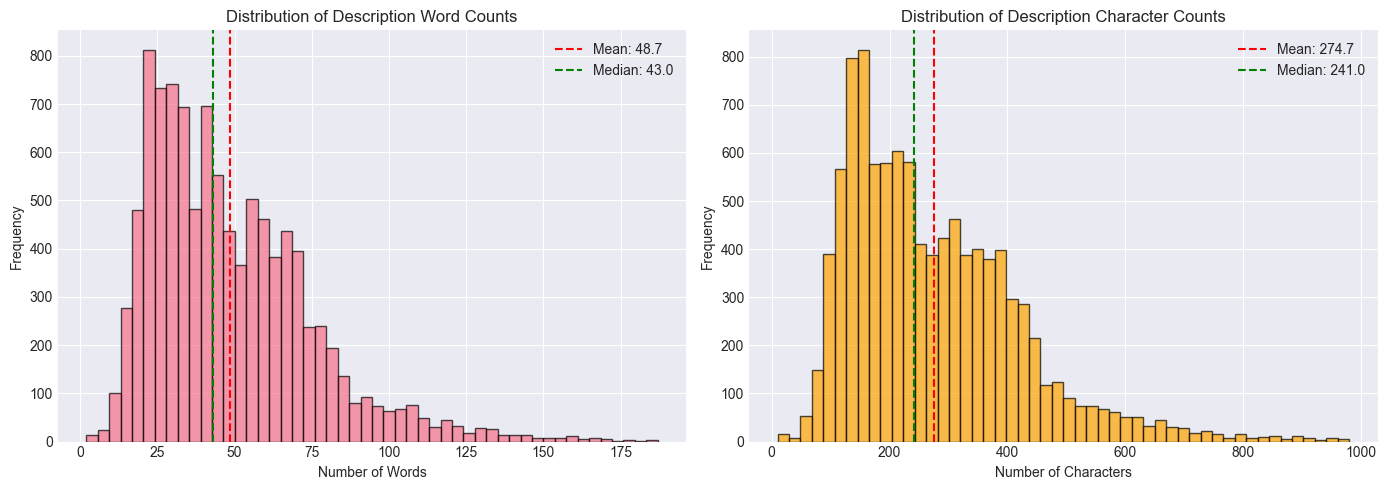

In [21]:
# Visualize text length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Word count distribution
axes[0].hist(df_meta['word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_meta['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_meta["word_count"].mean():.1f}')
axes[0].axvline(df_meta['word_count'].median(), color='green', linestyle='--',
                label=f'Median: {df_meta["word_count"].median():.1f}')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Description Word Counts')
axes[0].legend()

# Character count distribution
axes[1].hist(df_meta['char_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(df_meta['char_count'].mean(), color='red', linestyle='--',
                label=f'Mean: {df_meta["char_count"].mean():.1f}')
axes[1].axvline(df_meta['char_count'].median(), color='green', linestyle='--',
                label=f'Median: {df_meta["char_count"].median():.1f}')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Description Character Counts')
axes[1].legend()

plt.tight_layout()
plt.show()

In [22]:
# Show examples of preprocessing
print("Examples of Text Preprocessing:\n")

for i in range(3):
    print(f"Movie {i+1}: {df_meta.loc[i, 'names']}")
    print(f"Original ({len(df_meta.loc[i, 'overview'])} chars):")
    print(f"  {df_meta.loc[i, 'overview'][:150]}...")
    print(f"Processed ({len(df_meta.loc[i, 'overview_processed'])} chars):")
    print(f"  {df_meta.loc[i, 'overview_processed'][:150]}...")
    print()

Examples of Text Preprocessing:

Movie 1: Creed III
Original (458 chars):
  After dominating the boxing world, Adonis Creed has been thriving in both his career and family life. When a childhood friend and former boxing prodig...
Processed (447 chars):
  after dominating the boxing world adonis creed has been thriving in both his career and family life when a childhood friend and former boxing prodigy ...

Movie 2: Avatar: The Way of Water
Original (272 chars):
  Set more than a decade after the events of the first film, learn the story of the Sully family (Jake, Neytiri, and their kids), the trouble that follo...
Processed (262 chars):
  set more than a decade after the events of the first film learn the story of the sully family jake neytiri and their kids the trouble that follows the...

Movie 3: The Super Mario Bros. Movie
Original (252 chars):
  While working underground to fix a water main, Brooklyn plumbers—and brothers—Mario and Luigi are transported down a mysterious pipe and 

## 3. Embedding Statistics

In [23]:
# Embedding statistics
print("Embedding Statistics:")
print(f"Shape: {embeddings.shape}")
print(f"Total embeddings: {embeddings.shape[0]:,}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"\nValue statistics:")
print(f"Mean: {embeddings.mean():.6f}")
print(f"Std:  {embeddings.std():.6f}")
print(f"Min:  {embeddings.min():.6f}")
print(f"Max:  {embeddings.max():.6f}")

Embedding Statistics:
Shape: (10178, 384)
Total embeddings: 10,178
Embedding dimension: 384

Value statistics:
Mean: -0.000661
Std:  0.051027
Min:  -0.257004
Max:  0.251858


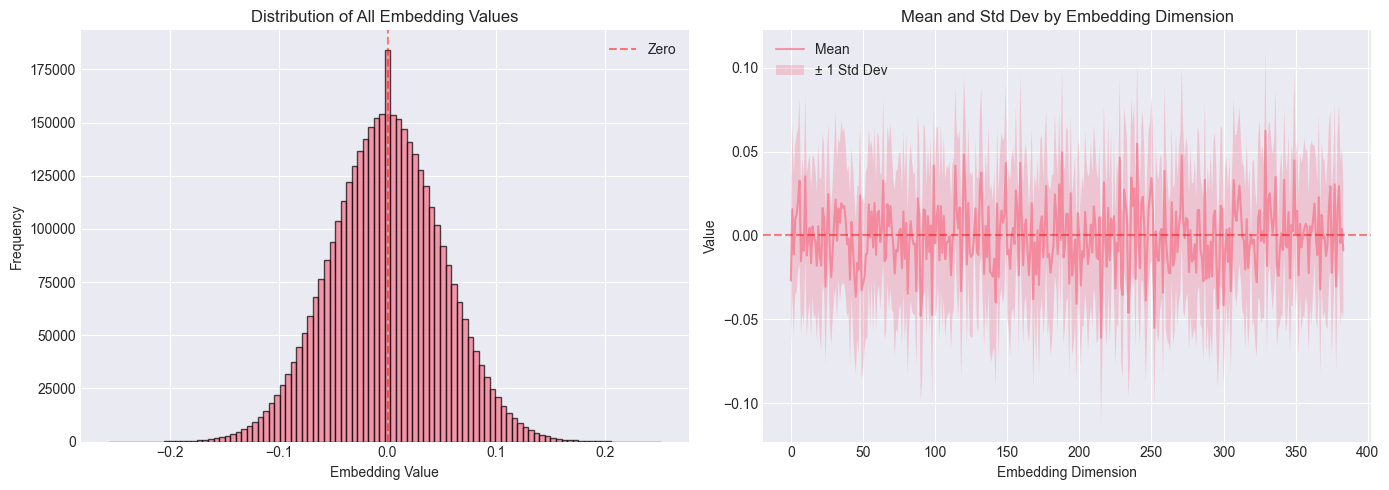

In [24]:
# Visualize embedding value distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(embeddings.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Embedding Values')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero')
axes[0].legend()

# Per-dimension statistics
dim_means = embeddings.mean(axis=0)
dim_stds = embeddings.std(axis=0)
axes[1].plot(dim_means, alpha=0.7, label='Mean')
axes[1].fill_between(range(len(dim_means)), 
                       dim_means - dim_stds, 
                       dim_means + dim_stds, 
                       alpha=0.3, label='± 1 Std Dev')
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_ylabel('Value')
axes[1].set_title('Mean and Std Dev by Embedding Dimension')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Dimensionality Reduction and Visualization

In [25]:
# t-SNE visualization
from sklearn.manifold import TSNE

print("Computing t-SNE (this may take a few minutes)...")

# Use a subset for faster computation (optional)
n_samples = min(5000, len(embeddings))
sample_indices = np.random.choice(len(embeddings), n_samples, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings[sample_indices])

print(f"t-SNE complete. Shape: {embeddings_2d.shape}")

Computing t-SNE (this may take a few minutes)...
t-SNE complete. Shape: (5000, 2)


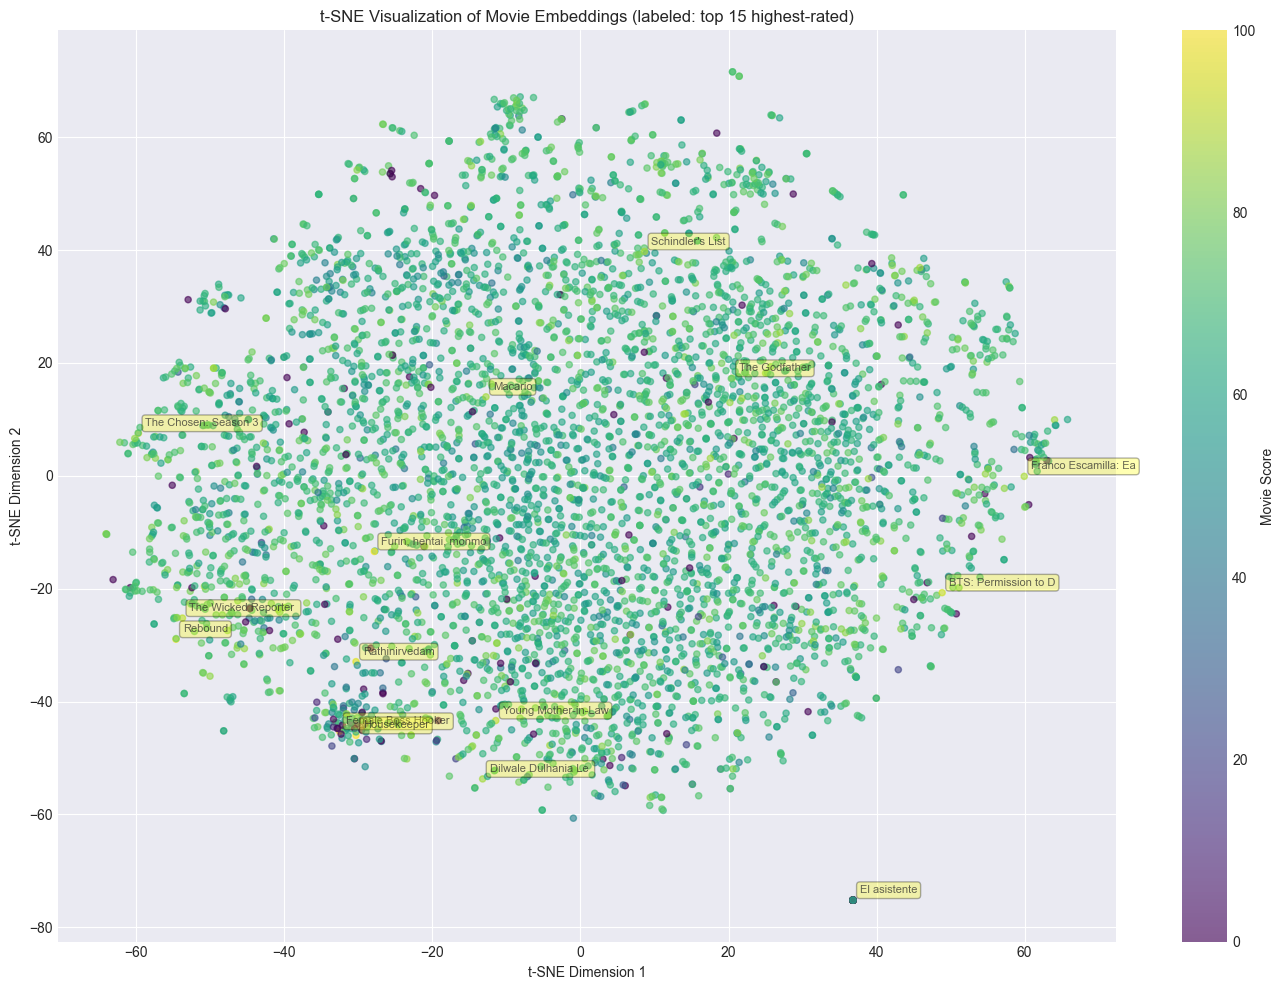

In [46]:
# Visualize t-SNE by movie score
plt.figure(figsize=(14, 10))

scores = df_meta.loc[sample_indices, 'score'].values
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=scores, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Movie Score')

# Add labels for some notable movies
movies_to_label = df_meta.loc[sample_indices].nlargest(15, 'score')

for idx, row in movies_to_label.iterrows():
    pos_in_sample = np.where(sample_indices == idx)[0]
    if len(pos_in_sample) > 0:
        pos = pos_in_sample[0]
        plt.annotate(
            row['names'][:20], 
            xy=(embeddings_2d[pos, 0], embeddings_2d[pos, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
        )

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Movie Embeddings (labeled: top 15 highest-rated)')
plt.tight_layout()
plt.show()

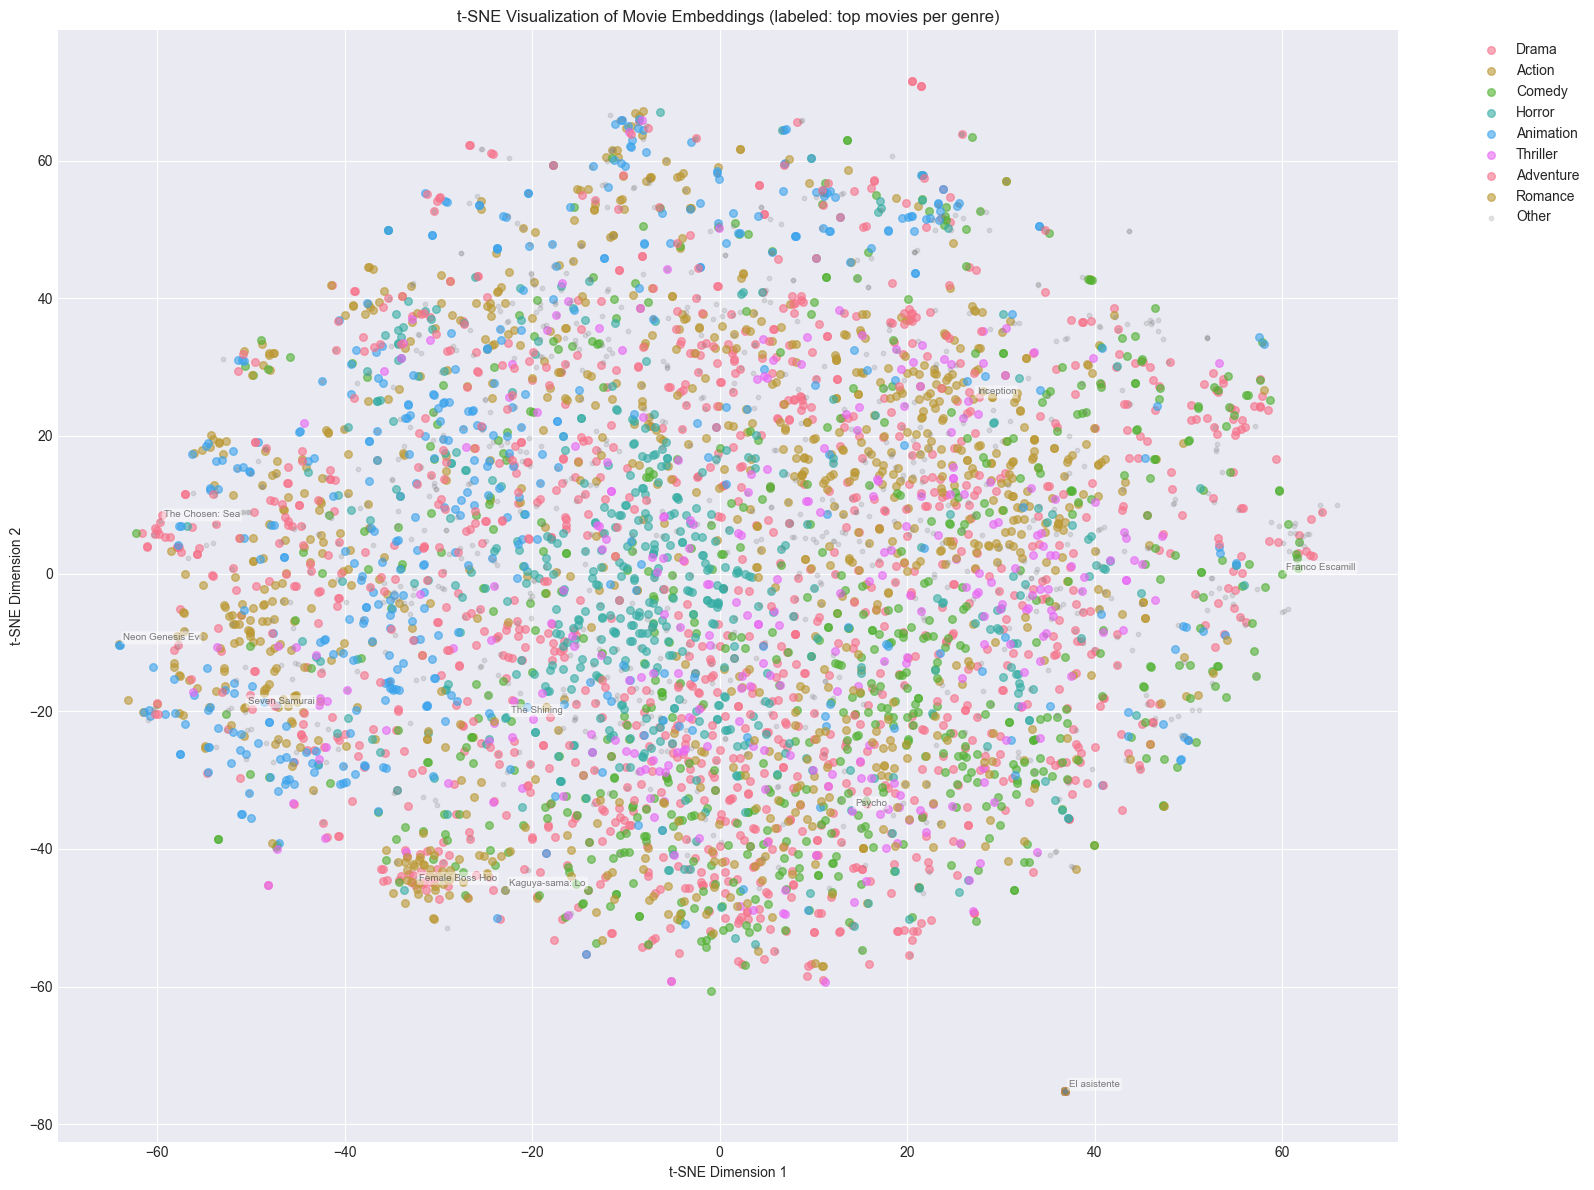

In [47]:
# Plot t-SNE colored by top genres
plt.figure(figsize=(16, 12))

sample_genres = df_meta.loc[sample_indices, 'first_genre'].values

# Plot each genre separately
for genre in top_genres:
    mask = sample_genres == genre
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                label=genre, alpha=0.6, s=30)

# Plot others in gray
other_mask = ~np.isin(sample_genres, top_genres)
plt.scatter(embeddings_2d[other_mask, 0], embeddings_2d[other_mask, 1], 
            label='Other', alpha=0.2, s=10, color='gray')

# Add labels for a few representative movies from each top genre
for genre in top_genres[:5]:
    genre_movies = df_meta.loc[sample_indices][df_meta.loc[sample_indices, 'first_genre'] == genre]
    # Get 2 highest-rated movies from this genre
    top_genre_movies = genre_movies.nlargest(2, 'score')
    
    for idx, row in top_genre_movies.iterrows():
        pos_in_sample = np.where(sample_indices == idx)[0]
        if len(pos_in_sample) > 0:
            pos = pos_in_sample[0]
            plt.annotate(
                row['names'][:15],
                xy=(embeddings_2d[pos, 0], embeddings_2d[pos, 1]),
                xytext=(3, 3),
                textcoords='offset points',
                fontsize=7,
                alpha=0.6,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.5, edgecolor='none')
            )

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Movie Embeddings (labeled: top movies per genre)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

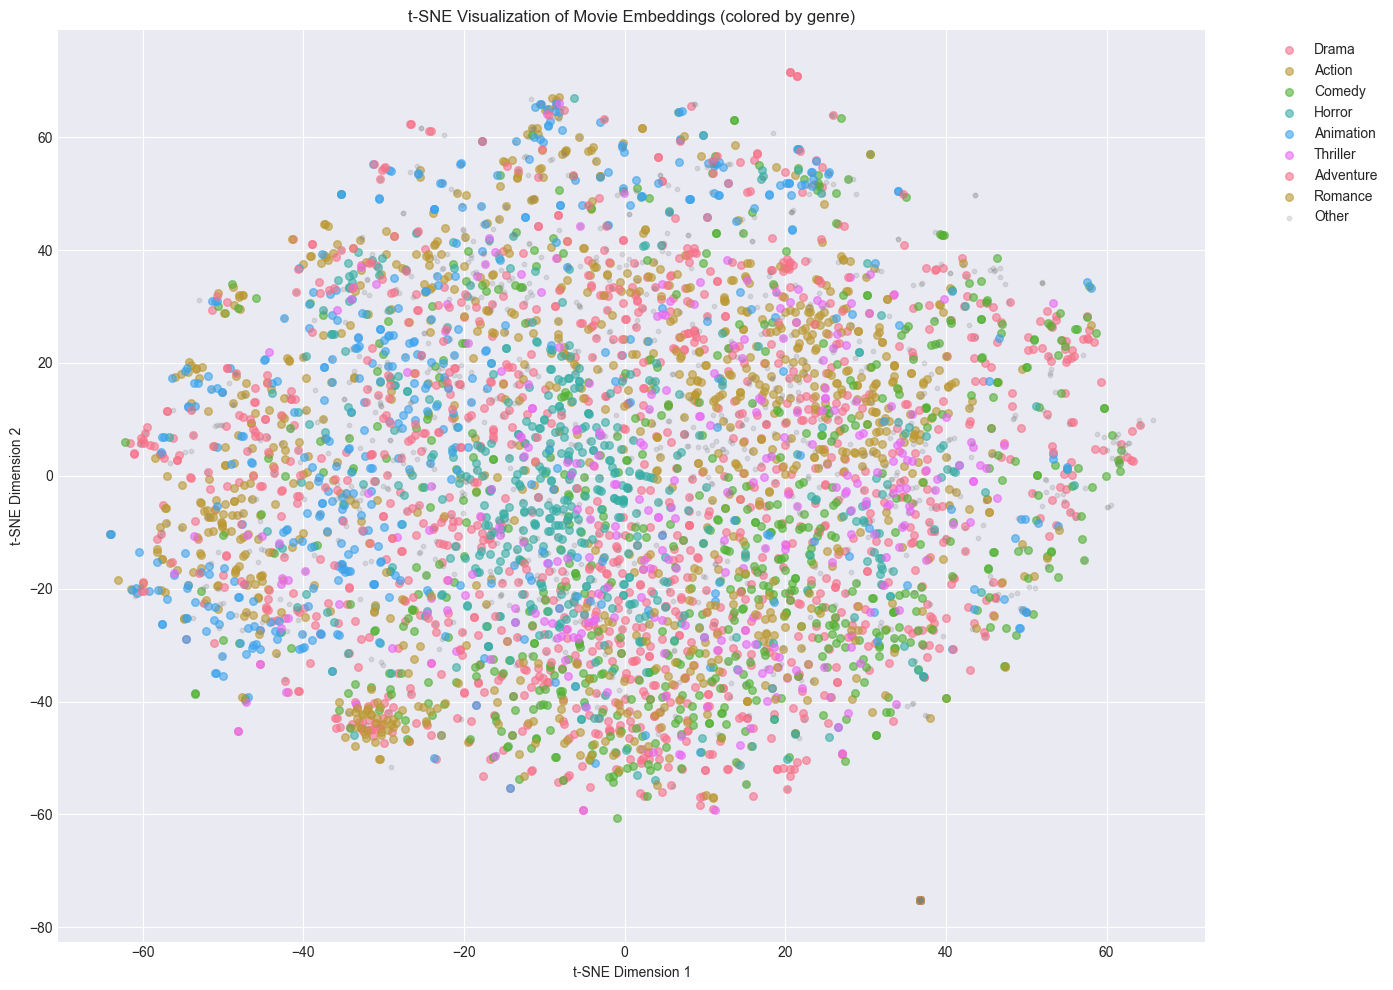

In [28]:
# Plot t-SNE colored by top genres
plt.figure(figsize=(14, 10))

sample_genres = df_meta.loc[sample_indices, 'first_genre'].values

# Plot each genre separately
for genre in top_genres:
    mask = sample_genres == genre
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                label=genre, alpha=0.6, s=30)

# Plot others in gray
other_mask = ~np.isin(sample_genres, top_genres)
plt.scatter(embeddings_2d[other_mask, 0], embeddings_2d[other_mask, 1], 
            label='Other', alpha=0.2, s=10, color='gray')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Movie Embeddings (colored by genre)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Recommendation System Examples

In [29]:
# Create recommender system
recommender = SemanticRecommender(df_meta, embeddings)
print("Recommender initialized")

Recommender initialized


In [30]:
# Example 1: Action movie recommendations
print("Example 1: Recommendations for 'Avatar'\n")

recommendations = recommender.get_similar_movies('Avatar', top_n=5)

if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['names']}")
        print(f"  Similarity: {row['similarity_score']:.3f} | Score: {row['score']:.1f} | Year: {int(row['year'])}")
        print(f"  Genre: {row['genre']}")
        print(f"  {row['overview'][:150]}...")
        print()

Example 1: Recommendations for 'Avatar'


Finding recommendations for: Avatar
Battle: Los Angeles
  Similarity: 0.489 | Score: 57.0 | Year: 2011
  Genre: Science Fiction, Action
  When once distant UFOs become a terrifying threat attacking Earth, a Marine staff sergeant and his team take it upon themselves to face the enemy and ...

Doom: Annihilation
  Similarity: 0.453 | Score: 49.0 | Year: 2019
  Genre: Action, Science Fiction, Horror, Mystery
  A group of UAC Marines responds to a distress call from a top-secret scientific base on Phobos, a Martian moon, only to discover it's been overrun by ...

Alien Resurrection
  Similarity: 0.445 | Score: 61.0 | Year: 1998
  Genre: Science Fiction, Horror, Action
  Two hundred years after Lt. Ripley died, a group of scientists clone her, hoping to breed the ultimate weapon. But the new Ripley is full of surprises...

Age of Tomorrow
  Similarity: 0.442 | Score: 30.0 | Year: 2014
  Genre: Thriller, Science Fiction, Action
  Mankind must fight t

In [31]:
# Example 2: Animation movie recommendations
print("Example 2: Recommendations for 'Toy Story'\n")

recommendations = recommender.get_similar_movies('Toy Story', top_n=5)

if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['names']}")
        print(f"  Similarity: {row['similarity_score']:.3f} | Score: {row['score']:.1f} | Year: {int(row['year'])}")
        print(f"  Genre: {row['genre']}")
        print(f"  {row['overview'][:150]}...")
        print()

Example 2: Recommendations for 'Toy Story'


Finding recommendations for: Toy Story
Toy Story 2
  Similarity: 0.741 | Score: 76.0 | Year: 1999
  Genre: Animation, Comedy, Family
  Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, ...

Toy Story 3
  Similarity: 0.740 | Score: 78.0 | Year: 2010
  Genre: Animation, Family, Comedy
  Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally le...

Toy Story 4
  Similarity: 0.596 | Score: 75.0 | Year: 2019
  Genre: Family, Adventure, Animation, Comedy, Fantasy
  Woody has always been confident about his place in the world and that his priority is taking care of his kid, whether that's Andy or Bonnie. But when ...

Beyond Infinity: Buzz and the Journey to Lightyear
  Similarity: 0.584 | Score: 71.0 | Year: 2022
  Genre: Documentary
  Explore the evolution 

In [32]:
# Example 3: Drama movie recommendations
print("Example 3: Recommendations for 'The Whale'\n")

recommendations = recommender.get_similar_movies('The Whale', top_n=5)

if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['names']}")
        print(f"  Similarity: {row['similarity_score']:.3f} | Score: {row['score']:.1f} | Year: {int(row['year'])}")
        print(f"  Genre: {row['genre']}")
        print(f"  {row['overview'][:150]}...")
        print()

Example 3: Recommendations for 'The Whale'


Finding recommendations for: The Whale
Piggy
  Similarity: 0.527 | Score: 66.0 | Year: 2022
  Genre: Thriller, Drama, Horror
  A bullied overweight teenager sees a glimpse of hope when her tormentors are brutally abducted by a mesmerizing stranger....

Silver Linings Playbook
  Similarity: 0.520 | Score: 71.0 | Year: 2013
  Genre: Drama, Comedy, Romance
  After spending eight months in a mental institution, a former teacher moves back in with his parents and tries to reconcile with his ex-wife....

Dead Poets Society
  Similarity: 0.513 | Score: 83.0 | Year: 1989
  Genre: Drama
  At an elite, old-fashioned boarding school in New England, a passionate English teacher inspires his students to rebel against convention and seize th...

Black Island
  Similarity: 0.513 | Score: 60.0 | Year: 2021
  Genre: Thriller
  The dark secrets of a seemingly peaceful island threaten to swallow up an orphaned student when he grows close to a mysterious new te

## 6. Similarity Analysis

In [33]:
# Compute full similarity matrix for a subset
from sklearn.metrics.pairwise import cosine_similarity

# Select popular movies for heatmap
popular_movies = df_meta.nlargest(20, 'score')
popular_indices = popular_movies.index.tolist()
popular_embeddings = embeddings[popular_indices]

# Compute similarity matrix
similarity_matrix = cosine_similarity(popular_embeddings)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Movies analyzed: {popular_movies['names'].tolist()}")

Similarity matrix shape: (20, 20)
Movies analyzed: ['Orgasm Lecture 2', 'El asistente', 'Female Boss Hooker', 'Porno document: Toruko tokkyû bin', 'Pretty Young Sister 4', 'The Chosen: Season 3  - Episodes 1 & 2', 'Furin, hentai, monmon chômon', 'Housekeeper', 'Simulant', 'Rebound', 'Rathinirvedam', 'Directing Annabelle: Creation', 'BTS: Permission to Dance on Stage - LA', 'Louis Tomlinson: All of Those Voices', 'La Usurpadora, the Musical', 'Young Mother-in-Law', "Oryu's Passion: Bondage Skin", 'The Wicked Reporter 2: The Rebirth of Horserace Betting', 'Hentai-shiatsu-shi: Shikiyoku no kyôen', 'Charlton Heston: Radical to Right Wing']


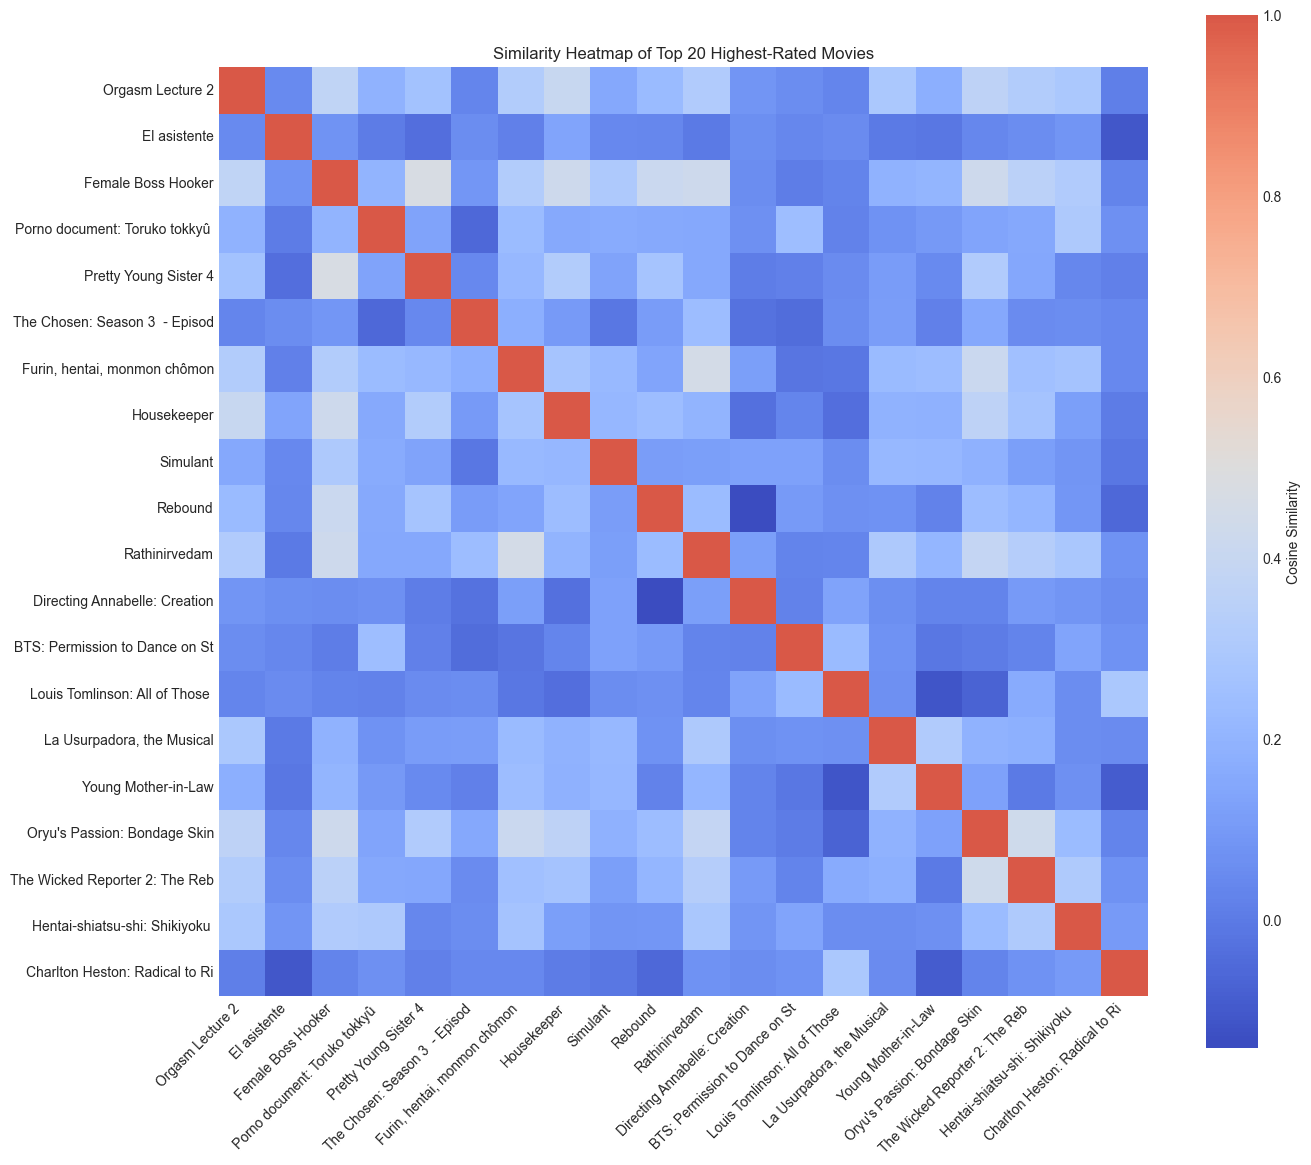

In [34]:
# Visualize similarity heatmap
plt.figure(figsize=(14, 12))

movie_labels = [name[:30] for name in popular_movies['names'].tolist()]

sns.heatmap(similarity_matrix, 
            xticklabels=movie_labels,
            yticklabels=movie_labels,
            cmap='coolwarm',
            center=0.5,
            annot=False,
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Cosine Similarity'})

plt.title('Similarity Heatmap of Top 20 Highest-Rated Movies')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
# Distribution of similarity scores
# Sample random pairs to avoid computing full matrix
n_pairs = 10000
idx1 = np.random.randint(0, len(embeddings), n_pairs)
idx2 = np.random.randint(0, len(embeddings), n_pairs)

# Compute pairwise similarities
similarities = []
for i in range(n_pairs):
    sim = cosine_similarity(
        embeddings[idx1[i]].reshape(1, -1),
        embeddings[idx2[i]].reshape(1, -1)
    )[0, 0]
    similarities.append(sim)

similarities = np.array(similarities)

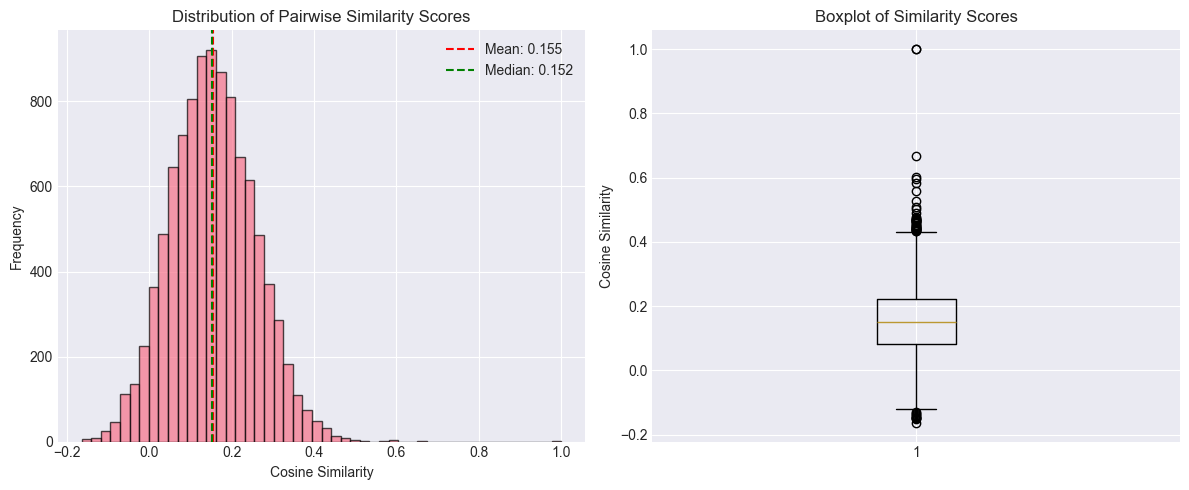

Similarity Statistics:
Mean: 0.1546
Std:  0.1018
Min:  -0.1636
Max:  1.0000


In [37]:
# Plot similarity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(similarities.mean(), color='red', linestyle='--', 
            label=f'Mean: {similarities.mean():.3f}')
plt.axvline(np.median(similarities), color='green', linestyle='--',
            label=f'Median: {np.median(similarities):.3f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarity Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(similarities)
plt.ylabel('Cosine Similarity')
plt.title('Boxplot of Similarity Scores')

plt.tight_layout()
plt.show()

print(f"Similarity Statistics:")
print(f"Mean: {similarities.mean():.4f}")
print(f"Std:  {similarities.std():.4f}")
print(f"Min:  {similarities.min():.4f}")
print(f"Max:  {similarities.max():.4f}")

## 7. Genre-Based Analysis

In [38]:
# Analyze similarity within and across genres
def compute_genre_similarities(df, embeddings, genre, n_samples=100):
    """
    Compute average similarity within a genre and with other genres.
    """
    genre_mask = df['first_genre'] == genre
    genre_indices = df[genre_mask].index.tolist()
    
    if len(genre_indices) < 2:
        return None, None
    
    # Sample if too many
    if len(genre_indices) > n_samples:
        genre_indices = np.random.choice(genre_indices, n_samples, replace=False)
    
    genre_embeddings = embeddings[genre_indices]
    
    # Within-genre similarity
    within_sim = cosine_similarity(genre_embeddings)
    # Remove diagonal (self-similarity)
    within_sim = within_sim[np.triu_indices_from(within_sim, k=1)]
    
    # Across-genre similarity
    other_indices = df[~genre_mask].index.tolist()
    if len(other_indices) > n_samples:
        other_indices = np.random.choice(other_indices, n_samples, replace=False)
    
    other_embeddings = embeddings[other_indices]
    across_sim = cosine_similarity(genre_embeddings, other_embeddings).flatten()
    
    return within_sim, across_sim

In [39]:
# Analyze top genres
genre_analysis = {}

for genre in top_genres:
    within, across = compute_genre_similarities(df_meta, embeddings, genre)
    if within is not None:
        genre_analysis[genre] = {
            'within_mean': within.mean(),
            'within_std': within.std(),
            'across_mean': across.mean(),
            'across_std': across.std(),
        }

# Display results
genre_df = pd.DataFrame(genre_analysis).T
genre_df['difference'] = genre_df['within_mean'] - genre_df['across_mean']
genre_df = genre_df.sort_values('difference', ascending=False)

print("Genre Similarity Analysis:")
print("\nGenres with highest within-genre similarity:")
print(genre_df[['within_mean', 'across_mean', 'difference']])

Genre Similarity Analysis:

Genres with highest within-genre similarity:
           within_mean  across_mean  difference
Horror        0.245870     0.156975    0.088895
Romance       0.228429     0.156348    0.072081
Thriller      0.203410     0.170914    0.032497
Action        0.180729     0.153192    0.027537
Adventure     0.170204     0.154279    0.015925
Animation     0.163551     0.149752    0.013799
Drama         0.166969     0.153631    0.013338
Comedy        0.159216     0.148855    0.010361


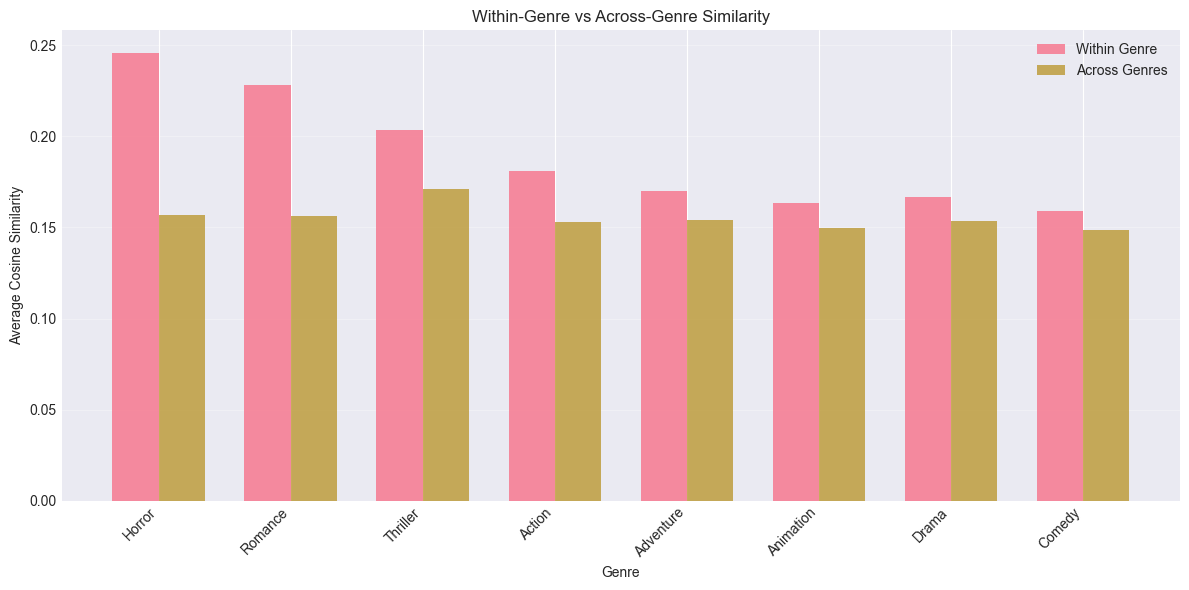

In [40]:
# Visualize genre similarity analysis
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(genre_df))
width = 0.35

ax.bar(x - width/2, genre_df['within_mean'], width, label='Within Genre', alpha=0.8)
ax.bar(x + width/2, genre_df['across_mean'], width, label='Across Genres', alpha=0.8)

ax.set_xlabel('Genre')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Within-Genre vs Across-Genre Similarity')
ax.set_xticks(x)
ax.set_xticklabels(genre_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Interactive Recommendation Testing

In [41]:
# Function to test recommendations interactively
def test_recommendation(movie_title, top_n=5):
    """
    Test recommendation system for a given movie.
    """
    print(f"\nRecommendations for: {movie_title}")
    print("="*80)
    
    recommendations = recommender.get_similar_movies(movie_title, top_n=top_n)
    
    if recommendations is not None:
        for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
            print(f"\n{i}. {row['names']}")
            print(f"   Similarity: {row['similarity_score']:.3f}")
            print(f"   Score: {row['score']:.1f} | Year: {int(row['year'])} | Genre: {row['genre']}")
            print(f"   {row['overview'][:200]}...")
    
    return recommendations

In [42]:
# Test with different movies
# Change the movie title to test different recommendations
test_recommendation('John Wick', top_n=5)


Recommendations for: John Wick

Finding recommendations for: John Wick

1. John Wick: Chapter 2
   Similarity: 0.705
   Score: 73.0 | Year: 2017 | Genre: Action, Thriller, Crime
   John Wick is forced out of retirement by a former associate looking to seize control of a shadowy international assassins’ guild. Bound by a blood oath to aid him, Wick travels to Rome and does battle...

2. John Wick: Chapter 3 - Parabellum
   Similarity: 0.640
   Score: 74.0 | Year: 2019 | Genre: Action, Thriller, Crime
   Super-assassin John Wick returns with a $14 million price tag on his head and an army of bounty-hunting killers on his trail. After killing a member of the shadowy international assassin’s guild, the ...

3. Lansky
   Similarity: 0.522
   Score: 62.0 | Year: 2021 | Genre: Crime, Drama, Thriller
   When the aging Meyer Lansky is investigated one last time by the Feds who suspect he has stashed away millions of dollars over half a century, the retired gangster spins a dizzying tale, revea

,names,similarity_score,score,year,genre,overview
35,John Wick: Chapter 2,0.705220,73.0,2017,"Action, Thriller, Crime",John Wick is forced out of retirement by a for...
39,John Wick: Chapter 3 - Parabellum,0.640213,74.0,2019,"Action, Thriller, Crime",Super-assassin John Wick returns with a $14 mi...
6378,Lansky,0.522009,62.0,2021,"Crime, Drama, Thriller",When the aging Meyer Lansky is investigated on...
6,John Wick: Chapter 4,0.513349,80.0,2023,"Action, Thriller, Crime","With the price on his head ever increasing, Jo..."
3454,The Smile of the Fox,0.442232,55.0,1992,Thriller,"Mark, a hitman haunted by his past as a corrup..."


In [45]:
# Test with custom description
custom_description = "A young wizard discovers his magical powers and must fight against dark forces to save the world."

print(f"Finding movies similar to: '{custom_description}'")
print("="*80)

# Load embedder
embedder = SemanticEmbedder(model_name='all-MiniLM-L6-v2')
embedder.load_model()

recommendations = recommender.get_recommendations_by_description(
    custom_description,
    embedder,
    top_n=5
)

for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
    print(f"\n{i}. {row['names']}")
    print(f"   Similarity: {row['similarity_score']:.3f}")
    print(f"   Score: {row['score']:.1f} | Year: {int(row['year'])} | Genre: {row['genre']}")
    print(f"   {row['overview'][:200]}...")

Finding movies similar to: 'A young wizard discovers his magical powers and must fight against dark forces to save the world.'
Loading SentenceTransformer model: all-MiniLM-L6-v2
Model loaded successfully. Embedding dimension: 384

1. Black Clover: Sword of the Wizard King
   Similarity: 0.591
   Score: 0.0 | Year: 2023 | Genre: Animation, Action, Fantasy
   In a world in which magic is everything, Asta, a boy who was born with no magic, aims to become the “Wizard King,” to overcome adversity, prove his power, and keep his oath with his friends....

2. The Kid Who Would Be King
   Similarity: 0.570
   Score: 61.0 | Year: 2019 | Genre: Action, Adventure, Fantasy, Family
   Old-school magic meets the modern world when young Alex stumbles upon the mythical sword Excalibur. He soon unites his friends and enemies, and they become knights who join forces with the legendary w...

3. The Wizard of Oz
   Similarity: 0.549
   Score: 76.0 | Year: 1940 | Genre: Adventure, Fantasy, Family
   Young 